### Mixture of two multivariate Gaussian distributions

• Simulate data from a mixture distribution of two multivariate normals given by

- X1 ∼ Np(μ1, Σ1)
- X2 ∼ Np(μ2, Σ2)

X = (1 − Z) · X1 + Z · X2 (1)

with binomially distributed Z ∈ {0, 1} with P (Z = 1) = τ . Note, the covariance matrices Σ1
and Σ2 need to be positive definite. You can choose p = 3

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 1000
p = 3
epsilon = 1e-7
# X1 distribution 
mu1 = np.array([3, 3, 3])
Sigma1 = np.array([[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]])
X1 = np.random.multivariate_normal(mu1, Sigma1, n)

# X2 distribution
mu2 = np.array([1, 1, 1])
Sigma2 = np.array([[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]])
X2 = np.random.multivariate_normal(mu2, Sigma2, n)

# Z distribution
tau = 0.5
Z = np.random.binomial(1, tau, n)

# Mixture distribution
X = (1 - Z[:, np.newaxis]) * X1 + Z[:, np.newaxis] * X2
print(X)

theta_old = np.hstack((mu1, mu2, Sigma1.flatten(), Sigma2.flatten(), tau))


[[ 1.42022254  0.69876359  1.84777829]
 [ 0.01080898  0.93766313 -0.53354862]
 [ 1.99367581  2.69106439  0.49741646]
 ...
 [ 1.85061488  1.94955666  2.73408392]
 [ 0.75094734  0.14179447  0.53165963]
 [ 0.90359729  0.81522564  1.19887003]]


Implement an EM algorithm to estimate Θ = [μ1, μ2, Σ1, Σ2, τ ] from your simulated data. 

Imple-ment a stopping criteria to terminate your algorithm. You can use, e.g., 

R(t) = ||θ(t)−θ(t−1)||2||θ(t−1)||2 < ϵ,

where ϵ = 10−6 and θ is a vector containing all parameters from Θ.

• Compare your estimates with the ground truth of your si

In [54]:
from scipy.stats import multivariate_normal

# Initialize parameters (estimates)
tau_est = 0.6  # Initial estimate for tau
mu1_est = np.random.rand(p)
mu2_est = np.random.rand(p)
Sigma1_est = np.eye(p)
Sigma2_est = np.eye(p)

# Define the parameter_vector function
def parameter_vector(tau, mu1, mu2, Sigma1, Sigma2):
    return np.concatenate((
        np.array([tau]),
        mu1,
        mu2,
        Sigma1.flatten(),
        Sigma2.flatten()
    ))

# Initialize parameters (estimates)
tau_est = 0.4  # Initial estimate for tau
mu1_est = np.random.rand(p)
mu2_est = np.random.rand(p)
Sigma1_est = np.eye(p)
Sigma2_est = np.eye(p)

# Initialize theta_old
theta_old = parameter_vector(tau_est, mu1_est, mu2_est, Sigma1_est, Sigma2_est)

# Initialize lists to store parameter values
tau_list = []
mu1_list = []
mu2_list = []
R_t_list = []
iteration_list = []

# EM Algorithm
for iteration in range(1, max_iter + 1):
    # E-step: Compute responsibilities
    resp1 = tau_est * multivariate_normal.pdf(X, mean=mu1_est, cov=Sigma1_est)
    resp2 = (1 - tau_est) * multivariate_normal.pdf(X, mean=mu2_est, cov=Sigma2_est)
    gamma = resp1 / (resp1 + resp2 + 1e-12)  # Added small value to avoid division by zero

    # M-step: Update estimates
    tau_est = np.mean(gamma)
    mu1_est = np.sum(gamma[:, np.newaxis] * X, axis=0) / np.sum(gamma)
    mu2_est = np.sum((1 - gamma)[:, np.newaxis] * X, axis=0) / np.sum(1 - gamma)

    X_mu1 = X - mu1_est
    X_mu2 = X - mu2_est

    Sigma1_est = np.dot((gamma[:, np.newaxis] * X_mu1).T, X_mu1) / np.sum(gamma)
    Sigma2_est = np.dot(((1 - gamma)[:, np.newaxis] * X_mu2).T, X_mu2) / np.sum(1 - gamma)

    # Ensure positive definiteness
    Sigma1_est += 1e-6 * np.eye(p)
    Sigma2_est += 1e-6 * np.eye(p)

    # Compute new parameter vector
    theta_new = parameter_vector(tau_est, mu1_est, mu2_est, Sigma1_est, Sigma2_est)

    # Convergence check
    R_t = np.linalg.norm(theta_new - theta_old, 2) / np.linalg.norm(theta_old, 2)

    # Store parameter values
    tau_list.append(tau_est)
    mu1_list.append(mu1_est.copy())
    mu2_list.append(mu2_est.copy())
    R_t_list.append(R_t)
    iteration_list.append(iteration)

    if R_t < epsilon:
        print(f"Converged at iteration {iteration}")
        break

    theta_old = theta_new.copy()
else:
    print("EM algorithm did not converge within the maximum number of iterations")

# Convert lists to arrays for easier plotting
mu1_array = np.array(mu1_list)
mu2_array = np.array(mu2_list)

Converged at iteration 566


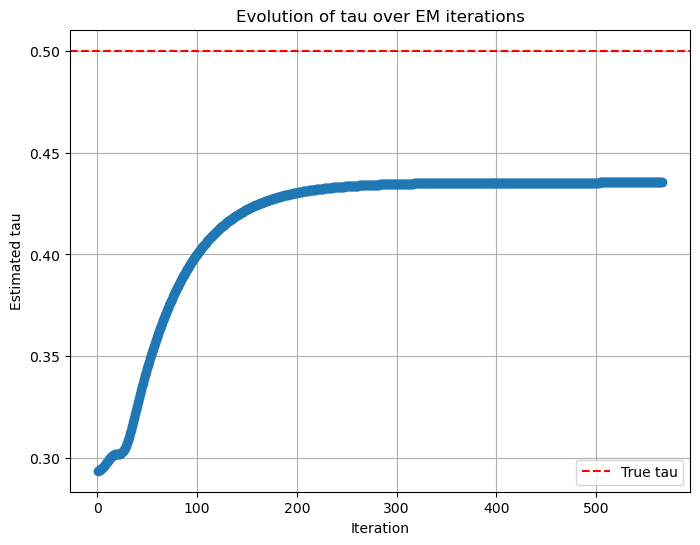

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(iteration_list, tau_list, marker='o')
plt.axhline(y=tau, color='r', linestyle='--', label='True tau')
plt.title('Evolution of tau over EM iterations')
plt.xlabel('Iteration')
plt.ylabel('Estimated tau')
plt.legend()
plt.grid(True)
plt.show()


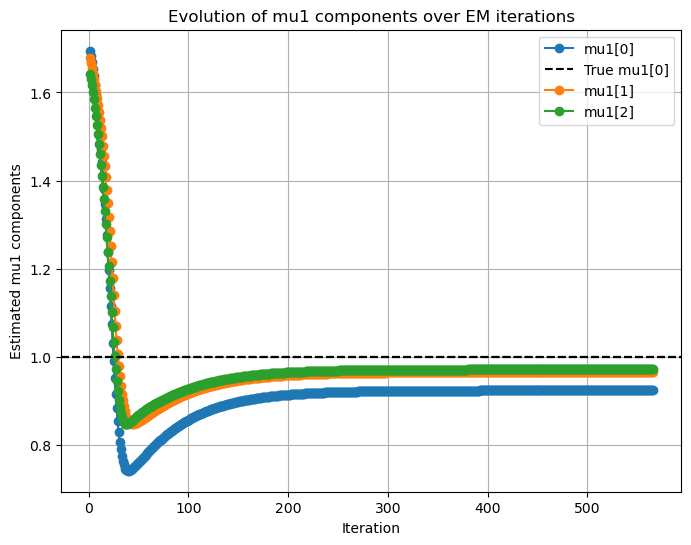

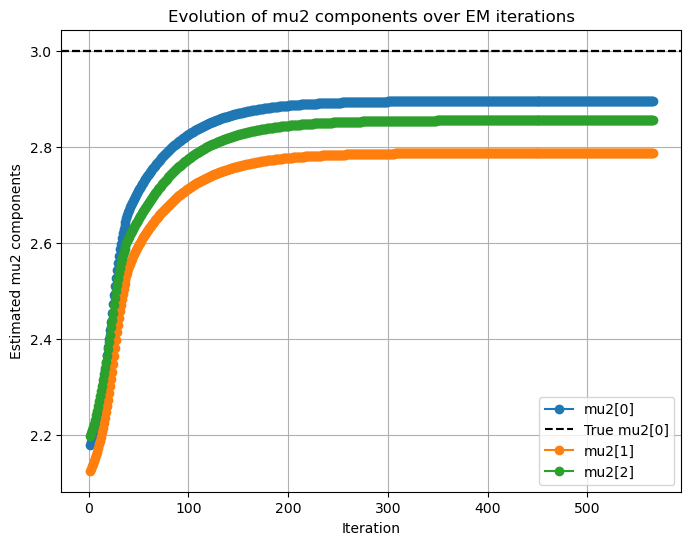

In [58]:
# Plot mu1 components
plt.figure(figsize=(8, 6))
for i in range(p):
    plt.plot(iteration_list, mu1_array[:, i], marker='o', label=f'mu1[{i}]')
    plt.axhline(y=mu2[i], color='k', linestyle='--', label=f'True mu1[{i}]' if i == 0 else "")

plt.title('Evolution of mu1 components over EM iterations')
plt.xlabel('Iteration')
plt.ylabel('Estimated mu1 components')
plt.legend()
plt.grid(True)
plt.show()

# Plot mu2 components
plt.figure(figsize=(8, 6))
for i in range(p):
    plt.plot(iteration_list, mu2_array[:, i], marker='o', label=f'mu2[{i}]')
    plt.axhline(y=mu1[i], color='k', linestyle='--', label=f'True mu2[{i}]' if i == 0 else "")

plt.title('Evolution of mu2 components over EM iterations')
plt.xlabel('Iteration')
plt.ylabel('Estimated mu2 components')
plt.legend()
plt.grid(True)
plt.show()


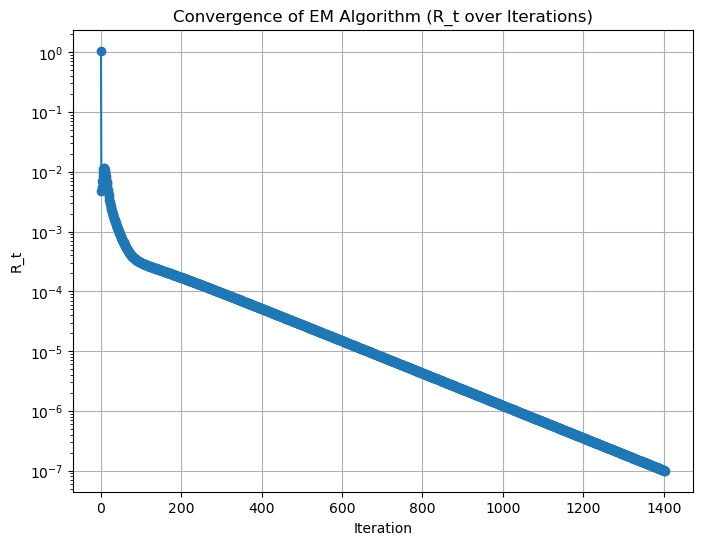

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(iteration_list, R_t_list, marker='o')
plt.title('Convergence of EM Algorithm (R_t over Iterations)')
plt.xlabel('Iteration')
plt.ylabel('R_t')
plt.yscale('log')  # Log scale to better visualize decreasing R_t
plt.grid(True)
plt.show()


In [64]:
#Initialize parameters (estimates)
p_C = 1/3
p_I = 1/3
p_T = 1/3
#Number of phenotype
n_C = 85    # Carbonaria phenotype count
n_I = 196   # Insularia phenotype count
n_T = 341   # Typica phenotype count
n = n_C + n_I + n_T



Converged at iteration 6


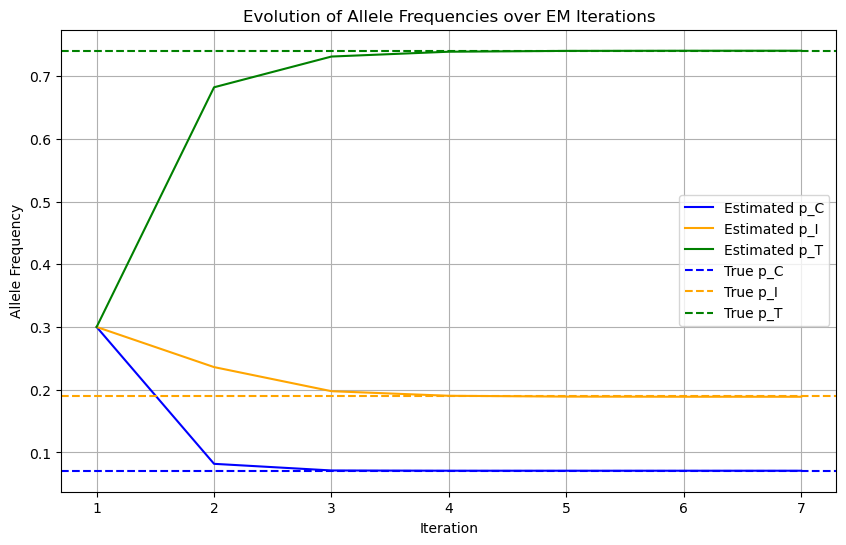

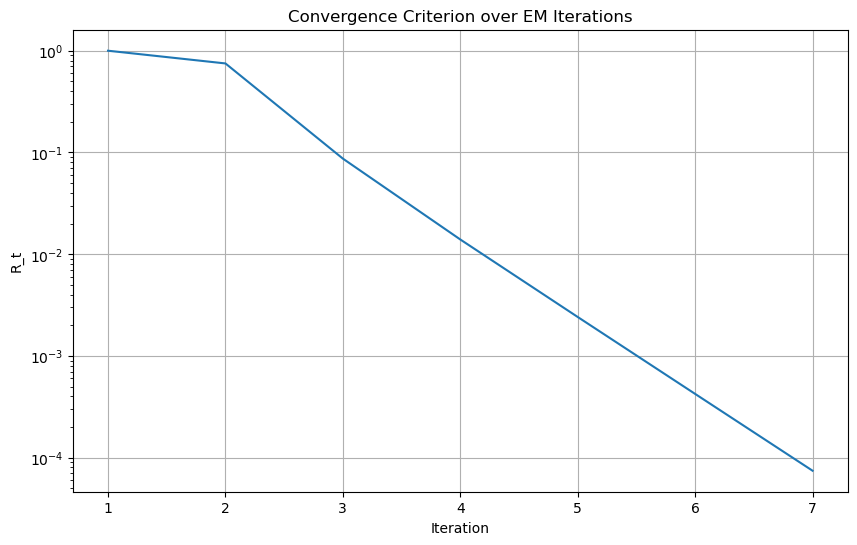

Estimated allele frequencies after 6 iterations:
p_C = 0.070837
p_I = 0.188745
p_T = 0.740418


In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Phenotype counts
n_C = 85    # Carbonaria phenotype count
n_I = 196   # Insularia phenotype count
n_T = 341   # Typica phenotype count
n = n_C + n_I + n_T

# Hypothetical true allele frequencies
p_C_true = 0.07
p_I_true = 0.19
p_T_true = 0.74

# Initialize parameters
p = np.array([0.33, 0.33, 0.34])  # Initial guesses [p_C, p_I, p_T]
epsilon = 1e-4
max_iter = 1000

# Lists to store parameter values for plotting
p_C_list = [0.3]
p_I_list = [0.3]
p_T_list = [0.3]
R_t_list = [1]

for t in range(max_iter):
    p_old = p.copy()

    # E-Step: Compute expected genotype counts

    # Carbonaria phenotype
    denom_C = p[0]**2 + 2*p[0]*p[1] + 2*p[0]*p[2]
    n_CC = n_C * (p[0]**2) / denom_C
    n_CI = n_C * (2*p[0]*p[1]) / denom_C
    n_CT = n_C * (2*p[0]*p[2]) / denom_C

    # Insularia phenotype
    denom_I = p[1]**2 + 2*p[1]*p[2]
    n_II = n_I * (p[1]**2) / denom_I
    n_IT = n_I * (2*p[1]*p[2]) / denom_I

    # Typica phenotype
    n_TT = n_T  # Since typica phenotype corresponds to genotype TT

    # M-Step: Update allele frequencies
    p_C = (2*n_CC + n_CI + n_CT) / (2*n)
    p_I = (2*n_II + n_CI + n_IT) / (2*n)
    p_T = (2*n_TT + n_CT + n_IT) / (2*n)

    p = np.array([p_C, p_I, p_T])

    # Store parameter values for plotting
    p_C_list.append(p_C)
    p_I_list.append(p_I)
    p_T_list.append(p_T)

    # Compute convergence criterion
    R_t = np.linalg.norm(p - p_old) / np.linalg.norm(p_old)
    R_t_list.append(R_t)

    if R_t < epsilon:
        print(f"Converged at iteration {t+1}")
        break
else:
    print("Did not converge within the maximum number of iterations")

# Plotting allele frequencies over iterations
iterations = range(1, len(p_C_list) + 1)
plt.figure(figsize=(10, 6))
plt.plot(iterations, p_C_list, label='Estimated p_C', color='blue')
plt.plot(iterations, p_I_list, label='Estimated p_I', color='orange')
plt.plot(iterations, p_T_list, label='Estimated p_T', color='green')

# Add horizontal lines for true allele frequencies
plt.axhline(y=p_C_true, color='blue', linestyle='--', label='True p_C')
plt.axhline(y=p_I_true, color='orange', linestyle='--', label='True p_I')
plt.axhline(y=p_T_true, color='green', linestyle='--', label='True p_T')

plt.xlabel('Iteration')
plt.ylabel('Allele Frequency')
plt.title('Evolution of Allele Frequencies over EM Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Plotting convergence criterion over iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, R_t_list)
plt.xlabel('Iteration')
plt.ylabel('R_t')
plt.title('Convergence Criterion over EM Iterations')
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.show()

# Print final estimated allele frequencies
print(f"Estimated allele frequencies after {t+1} iterations:")
print(f"p_C = {p[0]:.6f}")
print(f"p_I = {p[1]:.6f}")
print(f"p_T = {p[2]:.6f}")
